In [36]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import timm
import torch
import numpy as np

from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
from timm.data.loader import create_loader
from timm.data.dataset import ImageDataset
import torchvision.transforms as transforms

import os

from ViT.tooth_crop_dataset import ToothCropClassDataset
from utils.preprocess import rect_include_another, rotate_bounding_boxes, xyxy_reformat, xyxy2xywh
from utils.yolo import get_teeth_ROI
from utils.edge import tooth_isolation, bounding_teeth_on_origin, get_all_teeth

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline


# Model & env variable loaded

In [37]:
tooth_detect_model = torch.hub.load(r'.\YOLO', 'custom', path=r'.\YOLO\weights\8-bound.pt', source='local')
anomaly_detect_model = torch.hub.load(r'.\YOLO', 'custom', path=r'.\YOLO\weights\anomaly.pt', source='local')

data_dir = '.' / Path(os.getenv('DATASET_DIR'))


YOLOv5  torch 1.12.0 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 


requirements: D:\Users\douli\anaconda3\envs\dentist-CV-main\Lib\site-packages\yolov5\requirements.txt not found, check failed.


Model summary: 270 layers, 7041205 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  torch 1.12.0 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 


requirements: D:\Users\douli\anaconda3\envs\dentist-CV-main\Lib\site-packages\yolov5\requirements.txt not found, check failed.


Model summary: 270 layers, 7046599 parameters, 0 gradients
Adding AutoShape... 


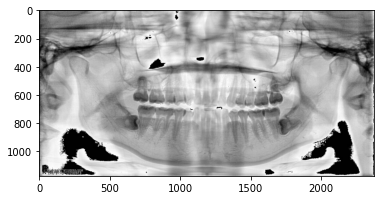

In [38]:
image_names = list(data_dir.glob('00008117.jpg'))

image_names = image_names[:20]
image_name = image_names[0]
filename = image_name.stem

im = cv2.imread(image_name)
# Only plt imshow need inverse process
plt.imshow(1 - im)
plt.show()


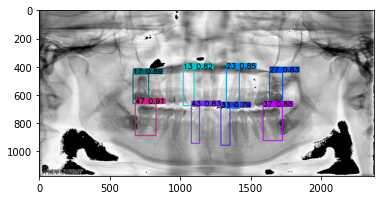

In [39]:
results = tooth_detect_model(image_names)
rendered_results = results.render()

plt.imshow(1 - rendered_results[0])
plt.show()


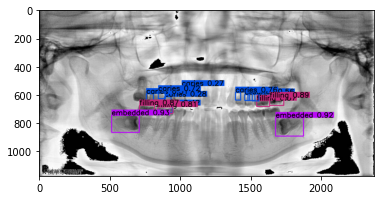

In [40]:
anomaly_results = anomaly_detect_model(image_names)
rendered_anomaly_results = anomaly_results.render()

plt.imshow(1 - rendered_anomaly_results[0])
plt.show()


In [41]:
results = tooth_detect_model(image_names)
teeth_region = get_all_teeth(results)
teeth_roi = get_teeth_ROI(results)

teeth_region


{'00008117': {'upper-left': {'crop_regions': {16: {'xyxy': tensor([ 78.,  84., 188., 283.]),
     'is_missing': False,
     'crop_image': array([[84, 83, 82, ..., 84, 84, 86],
            [82, 81, 80, ..., 88, 92, 94],
            [82, 78, 72, ..., 91, 96, 95],
            ...,
            [46, 54, 52, ..., 22, 17, 19],
            [46, 51, 49, ..., 22, 17, 19],
            [46, 46, 43, ..., 21, 16, 17]], dtype=uint8)},
    15: {'xyxy': tensor([188.,  84., 274., 283.]),
     'is_missing': False,
     'crop_image': array([[87, 89, 87, ..., 62, 59, 60],
            [90, 87, 85, ..., 66, 62, 63],
            [89, 84, 84, ..., 60, 62, 64],
            ...,
            [22, 19, 21, ..., 44, 47, 47],
            [22, 19, 19, ..., 44, 40, 45],
            [21, 18, 18, ..., 45, 37, 45]], dtype=uint8)},
    14: {'xyxy': tensor([274.,  84., 335., 283.]),
     'is_missing': True,
     'crop_image': array([[62, 66, 69, ..., 15, 14, 12],
            [66, 70, 73, ..., 15, 13, 12],
            [65, 6

# Save tooth crop image

In [42]:
temp_dir = '.' / Path(os.getenv('TEMP_DIR')) / 'crop_tooth_image'

missing_tooth = []
for file in temp_dir.glob('*.jpg'):
    os.remove(file)

for filename, region in teeth_region.items():
    for region_name, tooth_region in region.items():
        for tooth_number, data in tooth_region['crop_regions'].items():
            crop_image = data['crop_image']
            is_missing = data['is_missing']

            if is_missing:
                missing_tooth.append((filename, tooth_number))
                continue
            save_filepath = temp_dir / f'{filename} {region_name} {tooth_number}.jpg'

            temp_im = Image.fromarray(crop_image)
            temp_im.save(save_filepath)

# print(save_filepath)
missing_tooth


[('00008117', 14)]

In [43]:
tooth_region


{'crop_regions': {'47': {'xyxy': tensor([[683.48499],
           [664.60876],
           [830.96118],
           [888.10156]], device='cuda:0'),
   'crop_image': array([[[74, 74, 74],
           [74, 74, 74],
           [79, 79, 79],
           ...,
           [28, 28, 28],
           [30, 30, 30],
           [31, 31, 31]],
   
          [[78, 78, 78],
           [75, 75, 75],
           [77, 77, 77],
           ...,
           [23, 23, 23],
           [24, 24, 24],
           [24, 24, 24]],
   
          [[82, 82, 82],
           [76, 76, 76],
           [75, 75, 75],
           ...,
           [21, 21, 21],
           [20, 20, 20],
           [20, 20, 20]],
   
          ...,
   
          [[75, 75, 75],
           [75, 75, 75],
           [75, 75, 75],
           ...,
           [88, 88, 88],
           [89, 89, 89],
           [92, 92, 92]],
   
          [[79, 79, 79],
           [80, 80, 80],
           [80, 80, 80],
           ...,
           [91, 91, 91],
           [92, 92, 92

# Model loading

In [44]:
model_dir = '.' / Path(os.getenv('ViT_MODEL_DIR'))
model_path = model_dir / 'classifier-6.pt'

vit_model = timm.create_model('vit_base_patch16_224', num_classes=6)
vit_model.load_state_dict(torch.load(model_path))
vit_model


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): 

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_workers = 0

# Preprocess
transform = transforms.Compose([
    transforms.ToTensor(),
    # (lambda image: padding_to_size(image, 224)),
    transforms.Resize(size=(224, 224)),
    transforms.Normalize(mean=0.5, std=0.5),
])
target_transform = transforms.Compose([
    (lambda y: torch.Tensor(y)),
])
dataset = ImageDataset(temp_dir, transform=transform)

if torch.cuda.is_available():
    dataloader = create_loader(dataset, (3, 224, 224), 4)
else:
    dataloader = create_loader(dataset, (3, 224, 224), 4, use_prefetcher=False)


In [55]:
size = len(dataloader.dataset)

vit_model.to(device)
vit_model.eval()

threshold = 0.7
pred_encodes = []
# target_labels = ['caries', 'endo', 'post', 'crown']
target_labels = ['R.R', 'caries', 'crown', 'endo', 'filling', 'post']
with torch.no_grad():
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = vit_model(X)
        pred = torch.sigmoid(pred)
        pred_encode = pred > threshold
        pred_encodes.append(pred_encode.cpu().numpy())

pred_encodes = np.vstack(pred_encodes)
detected_list = [()] * len(pred_encodes)
for i, pred_encode in enumerate(pred_encodes):
    detected_list[i] = tuple((target_labels[j] for j, checker in enumerate(pred_encode) if checker))

detected_list


tensor([[ -8.29990,   5.03145, -11.12955, -10.85160,  -5.44791, -10.65896],
        [ -9.09696,   1.28626,  -7.42792,  -7.85867,  -3.66266,  -8.29840],
        [ -7.05567,   1.25814,  -8.96708,  -7.51545,  -3.92831,  -6.58409],
        [ -4.83368,   6.11096,  -8.14612,  -6.16073,  -8.68153,  -8.33039]], device='cuda:0')
tensor([[ -4.28279,   5.55037,  -8.70106,  -7.08581,  -7.88445,  -7.95772],
        [ -0.64495,   0.75187,  -7.49724,  -7.06780,  -5.11086,  -7.00377],
        [ -8.72334,  -3.77968,  -5.58586, -12.02902,   1.09800, -11.11403],
        [ -7.67387,   3.91219,  -9.47153,  -6.59712,  -5.19086,  -7.95505]], device='cuda:0')
tensor([[-12.10337,  -0.24171, -12.07210,  -8.18059,   1.90144, -13.14084],
        [ -2.36352,  -0.05197,  -6.37878,  -6.63571,  -3.78828,  -6.95461],
        [-13.25453,   0.59123, -12.65625,  -9.89499,   3.61265, -11.48271],
        [ -6.35088,  -0.94917,  -4.64294,  -3.48122,  -6.46305, -11.05711]], device='cuda:0')
tensor([[ -8.79859,   1.08408, -11

[('caries',),
 ('caries',),
 ('caries',),
 ('caries',),
 ('caries',),
 ('caries',),
 ('filling',),
 ('caries',),
 ('filling',),
 (),
 ('filling',),
 (),
 ('caries', 'filling'),
 ('caries',),
 ('filling',),
 (),
 ('caries', 'filling'),
 ('caries',),
 ('caries',),
 (),
 ('caries',),
 ('caries',),
 ('caries',),
 ('caries',),
 ()]

In [47]:
tooth_anomaly_dict = {}
for i, detected in enumerate(detected_list):
    current_filename, region_name, tooth_number = dataset.filename(i).split()
    tooth_number = int(tooth_number[:2])

    if current_filename not in tooth_anomaly_dict.keys():
        tooth_anomaly_dict[current_filename] = {}

    if tooth_number < 50:
        tooth_anomaly_dict[current_filename][tooth_number] = set(detected)

print(tooth_anomaly_dict)


{'00008117': {44: {'caries'}, 45: {'caries'}, 46: {'caries'}, 31: {'caries'}, 41: {'caries'}, 42: set(), 34: {'filling'}, 35: {'caries'}, 36: {'filling'}, 13: set(), 17: {'filling'}, 23: set(), 27: {'caries', 'filling'}, 33: {'caries'}, 37: {'filling'}, 43: set(), 47: {'caries', 'filling'}, 15: {'caries'}, 16: {'caries'}, 11: set(), 12: set(), 21: {'caries'}, 22: {'caries'}, 24: {'caries'}, 25: set()}}


# YOLO anomaly detect


In [50]:
iou_threshold = 0.5
region_wisdom_tooth_dict = {
    'upper-left': 18,
    'upper-right': 28,
    'lower-left': 48,
    'lower-right': 38,
}

for i in range(len(anomaly_results)):
    current_filename = anomaly_results.files[i][:-4]
    bounds = anomaly_results.xyxy[i]
    for j in range(len(bounds)):
        *xyxy, _, cls = bounds[j]
        xyxy = list(map(lambda t: t.cpu(), xyxy))

        cls = int(cls.item())
        name = anomaly_results.names[cls]
        if name in target_labels:
            continue

        # for x8 tooth
        if name in ['embedded', 'impacted']:
            print(name, ':')
            min_distance = np.inf
            near_region = ''
            for region_data in teeth_roi['images'][current_filename]:
                region_xyxy = region_data['xyxy']
                region_xywh = xyxy2xywh(np.vstack([region_xyxy]))[0]

                xywh = xyxy2xywh(np.vstack([xyxy]))[0]

                distance = np.linalg.norm(xywh[:2] - region_xywh[:2])
                if distance < min_distance:
                    min_distance = distance
                    near_region = f'{region_data["flag"]}-{region_data["tooth_position"]}'
            print(near_region)
            if near_region in region_wisdom_tooth_dict:
                tooth_number = region_wisdom_tooth_dict[near_region]
                if tooth_number not in tooth_anomaly_dict[current_filename].keys():
                    tooth_anomaly_dict[current_filename][tooth_number] = {name}
                else:
                    tooth_anomaly_dict[current_filename][tooth_number].add(name)
            continue

        # for normal tooth
        located_regions = {}
        for region_data in teeth_roi['images'][current_filename]:
            region_xyxy = region_data['xyxy']
            if rect_include_another(region_xyxy, xyxy) > iou_threshold:
                located_regions[f'{region_data["flag"]}-{region_data["tooth_position"]}'] = region_data

        for located_region, region_data in located_regions.items():
            region_tooth_data = teeth_region[current_filename][located_region]
            tooth_angle = np.radians(region_tooth_data['angle'])

            offset = region_data['offset']
            region_image_shape = np.array(np.array(region_data['image'].shape)[[1, 0]])

            rotated_xyxy = [xyxy]
            rotated_xyxy = np.array(rotated_xyxy) - np.tile(offset, 2)
            rotated_xyxy = rotate_bounding_boxes(tooth_angle, region_image_shape, rotated_xyxy)
            rotated_xyxy = rotated_xyxy[0].astype(int)
            for tooth_number, tooth_data in region_tooth_data['crop_regions'].items():
                tooth_xyxy = tooth_data['xyxy']

                if rect_include_another(tooth_xyxy, rotated_xyxy) > iou_threshold:
                    # if tooth_number not in result[current_filename].keys():
                    #     result[current_filename][tooth_number] = {name}
                    # else:
                    tooth_anomaly_dict[current_filename][tooth_number].add(name)

for pair in missing_tooth:
    filename, tooth_number = pair
    tooth_anomaly_dict[filename][tooth_number] = {'missing'}

print(tooth_anomaly_dict)


embedded :
lower-left
embedded :
lower-right
{'00008117': {44: {'caries'}, 45: {'caries'}, 46: {'caries'}, 31: {'caries'}, 41: {'caries'}, 42: set(), 34: {'filling'}, 35: {'caries'}, 36: {'filling'}, 13: set(), 17: {'filling'}, 23: set(), 27: {'caries', 'filling'}, 33: {'caries'}, 37: {'filling'}, 43: set(), 47: {'caries', 'filling'}, 15: {'caries'}, 16: {'caries'}, 11: set(), 12: set(), 21: {'caries'}, 22: {'caries'}, 24: {'caries'}, 25: set(), 48: {'embedded'}, 14: {'missing'}}}
